# BiLSTM-based classifier for Semantic Role Labeling

Importing needed packages

In [2]:
import numpy as np
import tensorflow
from tensorflow.keras import Sequential, Model, Input, optimizers
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model

import pandas as pd
from itertools import chain

from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences
# changed line:
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical

from gensim.models import KeyedVectors

import warnings
warnings.filterwarnings("ignore")

# reproducibility 
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

### 1. Let's begin by loading the dataset and defining paths

The dataset used for training is the English portion of the Universal Proposition Banks v1.0 (https://github.com/UniversalPropositions/UP-1.0). The paths to the evaluation, training and test set are defined below:

In [3]:
# Paths to the CONLLU data
path_train ='Data/en_ewt-up-train.conllu' 
path_eval = 'Data/en_ewt-up-dev.conllu' 
path_test = 'Data/en_ewt-up-test.conllu'
paths = [path_train, path_eval, path_test]

# Change to test when you are evaluating on test-set:
eval_split = 'dev'

# Embedding model
path_emb = 'Models/GoogleNews-vectors-negative300.bin'

# Output path model
output_path = 'bilstm-out1.csv'

For the implementation of the BiLSTM classifier, the data should be converted to an adapted .connlu file. The commented and empty sentences should be removed. Also, the sentences are repeated as many times as it contains predicates. The next functions helps us in doing so. 

In [4]:
def read_conllu_file(file_path):
    """
    Reads a CoNLL-U formatted file and returns a list of sentences, where each sentence is a list of token information.

    Args:
        file_path (str): The file path of the CoNLL-U file to be read.

    Returns:
        list: A list of sentences, where each sentence is represented as a list of token information.
    """
    
    sentences = []
    with open(file_path, "r", encoding = "utf-8") as file:
        sentence = []
        for line in file:
            line = line.strip()
            
            if line.startswith("#"):
                continue
            
            if not line:
                if sentence: 
                    sentences.append(sentence)
                    sentence = []
            
            else: 
                sentence.append(line.split("\t"))
                
        if sentence:
            sentences.append(sentence)
    return sentences

def copy_predicates(file_path):
    """
    Reads a CoNLL-U formatted file, finds sentences with multiple predicates, and creates new sentences by copying the original 
    sentence and changing the predicate values.

    Args:
        file_path (str): The file path of the CoNLL-U file to be read.

    Returns:
        list: A list of modified sentences, where each modified sentence is represented as a list of token information.
    """
    
    sentences = read_conllu_file(file_path)
    new_sentences = []
    
    for sentence in sentences: 
        #print(sentence)
        predicate_values = list([columns[10] for columns in sentence if len(columns) >= 11])
        predicate_values = [value for value in predicate_values if value != "_"]

        if len(predicate_values) <= 1:
            new_sentences.append(sentence)
        elif len(predicate_values) > 1: 
            for i, pred in enumerate(predicate_values):
                b = i + 1
                df = pd.DataFrame(sentence)
                df_2 = df.iloc[:, :11].copy()
                new_col = df.iloc[:, (10+b)]
                df_2[11] = new_col
                new_sentence = df_2.values.tolist()
                new_sentences.append(new_sentence)
    return new_sentences

def create_adapted_conll_files(file_paths):
    """
    Creates new CoNLL-U formatted files by adapting the original files with the 'copy_predicates' function. 

    Args:
        file_paths (list): A list of file paths to CoNLL-U formatted files to be adapted.

    Returns:
        list: A list of file paths to the newly created adapted CoNLL-U files.
    """
    
    adapted_paths = []
    for file_path in file_paths:
        sentences = copy_predicates(file_path)
        
        output_file = file_path.replace(".conllu", "_adapted.conllu")

        with open(output_file, "w", encoding = "utf-8") as outfile:
            for sentence in sentences:
                for columns in sentence:
                    if None in columns:
                        continue
                    else:
                        outfile.write("\t".join(columns) + "\n")
        adapted_paths.append(output_file)
    
    return adapted_paths

In [6]:
adapted_paths = create_adapted_conll_files(paths)

The adapted conll files are now read into a dataframe with use of the next defined function.

In [7]:
def convert_conll_to_df(paths):
    """
    Converts a list of CoNLL files to a pandas dataframe with additional columns for sentence ID and split ID.

    Args:
        paths (list): A list of file paths to CoNLL files.

    Returns:
        final_dataframe (pandas.DataFrame): A pandas dataframe containing the concatenated data from all input files with
                                             two additional columns, "# SENTENCE" and "SPLIT".
    """
    
    complete_dataframe  = []
    sentence_id = 0
    adapted_paths = create_adapted_conll_files(paths)
    
    for path in paths:
        suffix = path.split('.')[0]
        split = (suffix.split('-')[-1]).split('_')[0]
        print(split)
    
        df = pd.read_csv(path, delimiter='\t', header=None, on_bad_lines = "skip", engine = "python",
                    names=['ID', 'TOKEN', 'LEMMA', 'POS-UNIV', 'POS', 'MORPH', 'HEAD', 'BASIC-DEP', 'ENH-DEP', 
                           'SPACE', 'PREDICATE', 'LABEL'])
        df.dropna()
        # Adds the SPLIT column to the dataframe
        df['SPLIT'] = split
    
        # Adds the # SENTENCE column to the dataframe
        df['# SENTENCE'] = 0
        for index, row in df.iterrows():
            if row['ID'] == 1:
                sentence_id += 1
            df.at[index, '# SENTENCE'] = sentence_id
        
        # print(len(df))
        complete_dataframe.append(df)
        
    
    final_dataframe = pd.concat(complete_dataframe, ignore_index=True)

    return final_dataframe

In [8]:
adapted_paths

['Data/en_ewt-up-train_adapted.conllu',
 'Data/en_ewt-up-dev_adapted.conllu',
 'Data/en_ewt-up-test_adapted.conllu']

In [9]:
data = convert_conll_to_df(adapted_paths)

train
dev
test


In [10]:
data

,ID,TOKEN,LEMMA,POS-UNIV,POS,MORPH,HEAD,BASIC-DEP,ENH-DEP,SPACE,PREDICATE,LABEL,SPLIT,# SENTENCE
0,1.0,Al,Al,PROPN,NNP,Number=Sing,0,root,0:root,SpaceAfter=No,_,_,train,1
1,2.0,-,-,PUNCT,HYPH,_,1,punct,1:punct,SpaceAfter=No,_,_,train,1
2,3.0,Zaman,Zaman,PROPN,NNP,Number=Sing,1,flat,1:flat,_,_,_,train,1
3,4.0,:,:,PUNCT,:,_,1,punct,1:punct,_,_,_,train,1
4,5.0,American,american,ADJ,JJ,Degree=Pos,6,amod,6:amod,_,_,_,train,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237802,16.0,suggesting,suggest,VERB,VBG,VerbForm=Ger,7,conj,5:advcl:in|7:conj:and,_,suggest.01,_,test,52978
1237803,17.0,exercises,exercise,NOUN,NNS,Number=Plur,16,obj,16:obj,_,exercise.02,ARG1,test,52978
1237804,18.0,to,to,PART,TO,_,19,mark,19:mark,_,_,_,test,52978
1237805,19.0,use,use,VERB,VB,VerbForm=Inf,17,acl,17:acl:to,SpaceAfter=No,use.01,V,test,52978


In [11]:
data['LABEL'].value_counts()

_             1066210
V               50002
ARG1            34050
ARG0            18638
ARG2            12104
               ...   
C-ARGM-PRP          2
C-ARGM-ADV          1
C-ARGM-COM          1
C-ARGM-GOL          1
R-ARGM-ADJ          1
Name: LABEL, Length: 61, dtype: int64

### 2. Extract the mappings for the neural network

To train the BiLSTM classifier, two mappings are used as given below: 
- {token} to {token id}: address the row in the embeddings matrix for the current token
- {tag} to {tag id}: one-hot ground truth probability distribution vectors for computing the loss at the network's output

The next step is desired in any machine learning model, including the BiLSTM classifier, which requires integers as input. The function below 

In [12]:
from itertools import chain
def get_dict_map(data, token_or_tag):
    """
    Create two dictionaries to map tokens or tags to indices and vice versa.

    Args:
    - data (pandas.DataFrame): DataFrame containing the token and label columns.
    - token_or_tag 
    """ 
    
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'TOKEN':
        vocab = list(set(data['TOKEN'].to_list()))
    else:
        vocab = list(set(data['LABEL'].to_list()))
    
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    
    return tok2idx, idx2tok

In [13]:
token2idx, idx2token = get_dict_map(data, 'TOKEN')
tag2idx, idx2tag = get_dict_map(data, 'LABEL')

n_vocab, n_tags = len(token2idx), len(tag2idx)

In [14]:
print(n_vocab, n_tags) #TODO: WHY NOT 60 TAGS? 

22967 62


Two new index columns are added for the newly created variables WORD_IDX and TAG_IDX. 

In [15]:
# Adds the index information to the dataframe
data['WORD_IDX'] = data['TOKEN'].map(token2idx)
data['TAG_IDX'] = data['LABEL'].map(tag2idx)
data['PRED_IDX'] = data['LABEL'].apply(lambda x: 1 if x == 'V' else 0)

In [16]:
data.head()

,ID,TOKEN,LEMMA,POS-UNIV,POS,MORPH,HEAD,BASIC-DEP,ENH-DEP,SPACE,PREDICATE,LABEL,SPLIT,# SENTENCE,WORD_IDX,TAG_IDX,PRED_IDX
0,1.0,Al,Al,PROPN,NNP,Number=Sing,0,root,0:root,SpaceAfter=No,_,_,train,1,5509,60,0
1,2.0,-,-,PUNCT,HYPH,_,1,punct,1:punct,SpaceAfter=No,_,_,train,1,8001,60,0
2,3.0,Zaman,Zaman,PROPN,NNP,Number=Sing,1,flat,1:flat,_,_,_,train,1,5818,60,0
3,4.0,:,:,PUNCT,:,_,1,punct,1:punct,_,_,_,train,1,11689,60,0
4,5.0,American,american,ADJ,JJ,Degree=Pos,6,amod,6:amod,_,_,_,train,1,16282,60,0


### 3. Integrate the embeddings

In [ ]:
def integrate_emb(path_emb):
    w2v_model = KeyedVectors.load_word2vec_format(path_emb, binary=True)
    emb_dim = 300
    embedding_matrix = np.zeros((len(token2idx) + 1, emb_dim))
    print(embedding_matrix.shape)
    for word, i in token2idx.items():
        if word in w2v_model.key_to_index:
            embedding_vector = w2v_model[word]
        else:
            embedding_vector = None

        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    
    return w2v_model, emd_dim, embedding_matrix

In [17]:
w2v_model = KeyedVectors.load_word2vec_format(path_emb, binary=True)

In [18]:
# Create embedding matrix with zero vectors for oov words
emb_dim = 300
embedding_matrix = np.zeros((len(token2idx) + 1, emb_dim))
print(embedding_matrix.shape)
for word, i in token2idx.items():
    if word in w2v_model.key_to_index:
        embedding_vector = w2v_model[word]
    else:
        embedding_vector = None
        
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

(22968, 300)


In [19]:
# Check dimensions, store number of vector dimensions in variable
print(embedding_matrix.shape)
emb_dim = embedding_matrix.shape[1]
print(emb_dim)

(22968, 300)
300


### 4. Transform columns to extract sequential data

For making the recurrent neural network of it's best use, it'is best to collect tokens into arrays in the respective sequence.

In [ ]:
def transform_to_seq(data):
    data_fillna = data.fillna(method='ffill', axis=0)
    data_group = data_fillna.groupby(['# SENTENCE'],as_index=False)['ID', 'TOKEN', 'LEMMA', 'POS-UNIV', 'POS', 'MORPH', 'HEAD', 'BASIC-DEP', 
  'ENH-DEP', 'SPACE', 'PREDICATE', 'LABEL', 'SPLIT', '# SENTENCE', 'WORD_IDX', 'TAG_IDX'].agg(lambda x: list(x))
    

In [20]:
# Fills NaN in the SENTENCE # column using ffill in fillna
data_fillna = data.fillna(method='ffill', axis=0)

# Groups the # SENTENCE columns to get an array of tokens and tags
data_group = data_fillna.groupby(
['# SENTENCE'],as_index=False
)['ID', 'TOKEN', 'LEMMA', 'POS-UNIV', 'POS', 'MORPH', 'HEAD', 'BASIC-DEP', 
  'ENH-DEP', 'SPACE', 'PREDICATE', 'LABEL', 'SPLIT', '# SENTENCE', 'WORD_IDX', 'TAG_IDX'].agg(lambda x: list(x))
# Visualise data
data_group.tail()

,ID,TOKEN,LEMMA,POS-UNIV,POS,MORPH,HEAD,BASIC-DEP,ENH-DEP,SPACE,PREDICATE,LABEL,SPLIT,# SENTENCE,WORD_IDX,TAG_IDX,PRED_IDX
52973,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[He, listens, and, is, excellent, in, diagnosi...","[he, listen, and, be, excellent, in, diagnose,...","[PRON, VERB, CCONJ, AUX, ADJ, SCONJ, VERB, PUN...","[PRP, VBZ, CC, VBZ, JJ, IN, VBG, ,, VBG, CC, V...",[Case=Nom|Gender=Masc|Number=Sing|Person=3|Pro...,"[2, 0, 5, 5, 2, 7, 5, 9, 7, 11, 7, 14, 14, 7, ...","[nsubj, root, cc, cop, conj, mark, advcl, punc...","[2:nsubj|5:nsubj, 0:root, 5:cc, 5:cop, 2:conj:...","[_, _, _, _, _, _, SpaceAfter=No, _, _, _, _, ...","[_, listen.01, _, be.01, excel.01, _, diagnose...","[ARG0, _, _, _, _, _, _, _, _, _, V, _, _, ARG...","[test, test, test, test, test, test, test, tes...","[52974, 52974, 52974, 52974, 52974, 52974, 529...","[13, 17972, 1553, 18483, 18165, 16718, 18059, ...","[6, 60, 60, 60, 60, 60, 60, 60, 60, 60, 29, 60...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
52974,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[He, listens, and, is, excellent, in, diagnosi...","[he, listen, and, be, excellent, in, diagnose,...","[PRON, VERB, CCONJ, AUX, ADJ, SCONJ, VERB, PUN...","[PRP, VBZ, CC, VBZ, JJ, IN, VBG, ,, VBG, CC, V...",[Case=Nom|Gender=Masc|Number=Sing|Person=3|Pro...,"[2, 0, 5, 5, 2, 7, 5, 9, 7, 11, 7, 14, 14, 7, ...","[nsubj, root, cc, cop, conj, mark, advcl, punc...","[2:nsubj|5:nsubj, 0:root, 5:cc, 5:cop, 2:conj:...","[_, _, _, _, _, _, SpaceAfter=No, _, _, _, _, ...","[_, listen.01, _, be.01, excel.01, _, diagnose...","[_, _, _, _, _, _, _, _, _, _, _, _, ARGM-ADJ,...","[test, test, test, test, test, test, test, tes...","[52975, 52975, 52975, 52975, 52975, 52975, 529...","[13, 17972, 1553, 18483, 18165, 16718, 18059, ...","[60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 6...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
52975,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[He, listens, and, is, excellent, in, diagnosi...","[he, listen, and, be, excellent, in, diagnose,...","[PRON, VERB, CCONJ, AUX, ADJ, SCONJ, VERB, PUN...","[PRP, VBZ, CC, VBZ, JJ, IN, VBG, ,, VBG, CC, V...",[Case=Nom|Gender=Masc|Number=Sing|Person=3|Pro...,"[2, 0, 5, 5, 2, 7, 5, 9, 7, 11, 7, 14, 14, 7, ...","[nsubj, root, cc, cop, conj, mark, advcl, punc...","[2:nsubj|5:nsubj, 0:root, 5:cc, 5:cop, 2:conj:...","[_, _, _, _, _, _, SpaceAfter=No, _, _, _, _, ...","[_, listen.01, _, be.01, excel.01, _, diagnose...","[ARG0, _, _, _, _, _, _, _, _, _, _, _, _, _, ...","[test, test, test, test, test, test, test, tes...","[52976, 52976, 52976, 52976, 52976, 52976, 529...","[13, 17972, 1553, 18483, 18165, 16718, 18059, ...","[6, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
52976,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[He, listens, and, is, excellent, in, diagnosi...","[he, listen, and, be, excellent, in, diagnose,...","[PRON, VERB, CCONJ, AUX, ADJ, SCONJ, VERB, PUN...","[PRP, VBZ, CC, VBZ, JJ, IN, VBG, ,, VBG, CC, V...",[Case=Nom|Gender=Masc|Number=Sing|Person=3|Pro...,"[2, 0, 5, 5, 2, 7, 5, 9, 7, 11, 7, 14, 14, 7, ...","[nsubj, root, cc, cop, conj, mark, advcl, punc...","[2:nsubj|5:nsubj, 0:root, 5:cc, 5:cop, 2:conj:...","[_, _, _, _, _, _, SpaceAfter=No, _, _, _, _, ...","[_, listen.01, _, be.01, excel.01, _, diagnose...","[_, _, _, _, _, _, _, _, _, _, _, _, _, _, _, ...","[test, test, test, test, test, test, test, tes...","[52977, 52977, 52977, 52977, 52977, 52977, 529...","[13, 17972, 1553, 18483, 18165, 16718, 18059, ...","[60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 6...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
52977,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[He, listens, and, is, excellent, in, diagnosi...","[he, listen, and, be, excellent, in, diagnose,...","[PRON, VERB, CCONJ, AUX, ADJ, SCONJ, VERB, PUN...","[PRP, VBZ, CC, VBZ, JJ, IN, VBG, ,, VBG, CC, V...",[Case=Nom|Gender=Masc|Number=Sing|Person=3|Pro...,"[2, 0, 5

### 5. Split the dataset into the different splits after padding

In [24]:
def get_pad_train_test_val(data_group, data, eval_split="dev", n_vocab=n_vocab):
    """
    The function get_pad_train_test_val pads the token and tag sequences with zeros and generates one-hot encoded tags 
    for the input data. It then splits the dataset into train and evaluation sets based on the split ratio provided.

    Args:

    - data_group (pandas.DataFrame): A dataframe containing token and tag sequences, split information, and precomputed token and tag indices.
    - data (pandas.DataFrame): A dataframe containing token and tag sequences, split information, and precomputed token and tag indices.
    - eval_split (str): A string indicating the split to use for evaluation data (default is "dev").
    - n_vocab (int): The number of unique tokens in the token vocabulary (default is None).
    
    Returns:
    - train_tokens (numpy.ndarray): containing the padded and indexed train tokens.
    - eval_tokens (numpy.ndarray): containing the padded and indexed evaluation tokens.
    - train_tags (numpy.ndarray): containing the one-hot encoded tags for the train data.
    - eval_tags (numpy.ndarray): containing the one-hot encoded tags for the evaluation data.

    """
    
     # Pad tokens
    tokens = data_group['WORD_IDX'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value = n_vocab)

    #Pad Tags and convert it into one hot encoding
    tags = data_group['TAG_IDX'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int64', padding='post', value=tag2idx["_"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    
    #Split train, test and validation set
    train_tokens, eval_tokens, train_tags, eval_tags, train_preds, eval_preds = [], [], [], [], [], []
    for i, row in data_group.iterrows():
        if 'train' in row['SPLIT']:
            train_tokens.append(pad_tokens[i])
            train_tags.append(pad_tags[i])
        elif eval_split in row['SPLIT']:
            eval_tokens.append(pad_tokens[i])
            eval_tags.append(pad_tags[i])

    print(
        'evaluation based on:', eval_split,
        '\ntrain_tokens length:', len(train_tokens),
        '\ntrain_tags length:', len(train_tags),
        '\neval_tokens:', len(eval_tokens),
        '\neval_tags:', len(eval_tags),
    )
    
    return np.array(train_tokens), np.array(eval_tokens), np.array(train_tags), np.array(eval_tags)

train_tokens, eval_tokens, train_tags, eval_tags = get_pad_train_test_val(data_group, data, eval_split = "test")

evaluation based on: test 
train_tokens length: 42200 
train_tags length: 42200 
train_preds length: 42200 
eval_tokens: 5338 
eval_tags: 5338 
eval_preds: 5338


In [25]:
print(len(eval_tokens))
print(len(train_tokens))

5338
42200


### 6. Build the model

In [26]:
input_dim = len(list(set(data['TOKEN'].to_list()))) +1
output_dim = emb_dim # number of dimensions
input_length = max([len(s) for s in data_group['WORD_IDX'].tolist()])
n_tags = len(tag2idx)
print('input_dim: ', input_dim, 
      '\noutput_dim: ', output_dim, 
      '\ninput_length: ', input_length, 
      '\nn_tags: ', n_tags)

print('emb dim:', emb_dim)

input_dim:  22968 
output_dim:  300 
input_length:  558 
n_tags:  62
emb dim: 300


In [28]:
def get_bilstm_lstm_model(embedding_matrix, embedding_dim):
    """
    Creates a BiLSTM model with an embedding layer using the provided embedding matrix and dimensions.
    
    Parameters:
    embedding_matrix (numpy array): Pre-trained embedding matrix
    embedding_dim (int): Dimensions of the embedding layer
    
    Returns:
    model: A compiled BiLSTM model with TimeDistributed Dense layer for tagging
    """
    
    # Input layers for words
    word_input = Input(shape=(input_length,), dtype='int32', name='word_input')
    
    # Create a sequential model
    model = Sequential()

    # Add an embedding layer with pre-trained embedding matrix
    embedding_layer = Embedding(len(token2idx)+1 ,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=input_length,
                            trainable=False)
    model.add(embedding_layer)
 
    # Add a BiLSTM layer
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode='concat'))
    
    # Add a TimeDistributed Dense layer for tagging
    model.add(TimeDistributed(Dense(n_tags, activation="softmax")))
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

    model.summary()
    
    return model

In [29]:
def train_model(X, y, model):
    """Train a given Keras model on input-output pairs (X, y).

    Args:
    - X: the input data
    - y: the output data
    - model: the model to train.

    Returns:
    - loss: the training loss at the end of each epoch.
    """
    
    loss = list()
    # set epochs to 3 (from 25) (you can change this)
    for i in range(3):
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=200, verbose=1, epochs=3, validation_split=0.2)
        loss.append(hist.history['loss'][0])
    return loss

### 7. Train the model

In [30]:
from keras.layers import Input, concatenate
results = pd.DataFrame()
embedding_dim = 300 # dimensions of the word2vec vectors
model_bilstm_lstm = get_bilstm_lstm_model(embedding_matrix, embedding_dim)
plot_model(model_bilstm_lstm)
results['with_add_lstm_3ep'] = train_model(train_tokens, train_tags, model_bilstm_lstm)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 558, 300)          6890400   
                                                                 
 bidirectional (Bidirectiona  (None, 558, 600)         1442400   
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 558, 62)          37262     
 ibuted)                                                         
                                                                 
Total params: 8,370,062
Trainable params: 1,479,662
Non-trainable params: 6,890,400
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/

### 8. Evaluate the model

In [31]:
result = model_bilstm_lstm.evaluate(eval_tokens, np.array(eval_tags), batch_size=1)
print("test loss, test acc:", result)

5338/5338 [==============================] - 2546s 477ms/step - loss: 0.0174 - accuracy: 0.9946
test loss, test acc: [0.017375651746988297, 0.9946082234382629]


Text(0, 0.5, 'Loss')

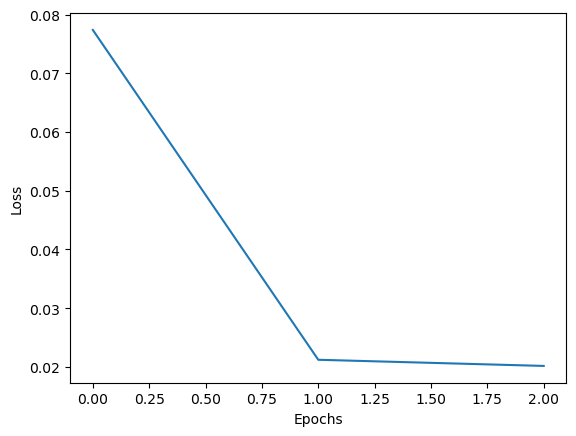

In [32]:
import matplotlib.pyplot as plt
plt.plot(results['with_add_lstm_5ep'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

### 9. Get model predictions

In [38]:
# Gets predictions on development set
y_pred = model_bilstm_lstm.predict(eval_tokens)

167/167 [==============================] - 117s 696ms/step


In [40]:
# Gets dimension index with highest probability (--> label)
y_pred = np.argmax(y_pred, axis=-1)
y_eval =  np.argmax(eval_tags, axis=-1)
print(y_pred)

[[37 60 60 ... 60 60 60]
 [60 60  6 ... 60 60 60]
 [37 60  6 ... 60 60 60]
 ...
 [60 60 60 ... 60 60 60]
 [60 60 60 ... 60 60 60]
 [60 60 60 ... 60 60 60]]


In [57]:
from sklearn.metrics import classification_report
import numpy as np

# Convert the predictions and true labels to their original tag forms (not one-hot encoded)
predicted_tags = np.argmax(y_pred, axis=-1)
true_tags = np.argmax(np.array(eval_tags), axis=-1)

# Create a reverse mapping from tag indices to tag names
idx2tag = {i: tag for tag, i in tag2idx.items()}

predicted_tags_names = []
true_tags_names = []

for true_seq, pred_seq in zip(true_tags, predicted_tags):
    for true_tag, pred_tag in zip(true_seq.ravel(), pred_seq.ravel()):
        # Ignore padding values when both true_tag and pred_tag are padding tags
        if not (true_tag == tag2idx["C-ARGM-GOL"] and pred_tag == tag2idx["C-ARGM-GOL"]):
            predicted_tags_names.append(idx2tag[pred_tag])
            true_tags_names.append(idx2tag[true_tag])

predicted_tags_names_filtered, true_tags_names_filtered = [], []
            
            
for predicted_tag_name, true_tag_name in zip(predicted_tags_names, true_tags_names):
    if predicted_tag_name is not None and true_tag_name is not None:
        predicted_tags_names_filtered.append(predicted_tag_name)
        true_tags_names_filtered.append(true_tag_name)

# Generate the classification report
report = classification_report(true_tags_names_filtered, predicted_tags_names_filtered, zero_division=0)

print(report)


              precision    recall  f1-score   support

        ARG0       0.00      0.00      0.00       478
        ARG1       0.00      0.00      0.00       257
        ARG2       0.00      0.00      0.00        21
    ARGM-ADJ       0.00      0.00      0.00        36
    ARGM-ADV       0.00      0.00      0.00        41
    ARGM-CAU       0.00      0.00      0.00         5
    ARGM-CXN       0.00      0.00      0.00         0
    ARGM-DIS       0.00      0.00      0.00       119
    ARGM-EXT       0.00      0.00      0.00         6
    ARGM-LOC       0.00      0.00      0.00         2
    ARGM-LVB       0.00      0.50      0.00         2
    ARGM-MNR       0.00      0.00      0.00         9
    ARGM-MOD       0.00      0.00      0.00        29
    ARGM-NEG       0.00      0.00      0.00         5
    ARGM-PRP       0.00      0.00      0.00         1
    ARGM-TMP       0.00      0.00      0.00        14
      C-ARG1       0.00      0.00      0.00         0
  C-ARGM-COM       0.00    